이 커널은 고전적인 이미지 기술을 구현하고 이전에 이미지 데이터로 작업해 본 적이 없는 사람들에게 유용한 입문서 역할을 할 수 있기를 바랍니다. 궁극적으로 우리는 테스트 이미지에 적용할 수 있는 'scipy'와 'numpy'(그리고 약간의 'scickit-image')를 사용하는 간단한 파이프라인을 개발할 것입니다. 사실, 우리는 매개 변수를 최적화하는 것 외에는 훈련 이미지를 사용하지 않을 것입니다.

이 노트북을 계속 업데이트하여 개선해 보겠습니다. 사용자 Gabro Vecsei도 비슷한 접근 방식을 취하며 [이 커널]((https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229))에서 0.22점을 받았습니다. 하지만 여기서 저의 주된 의도는 분석을 처음 접하는 사람들을 돕는 것이지, 높은 점수를 받는 것은 아닙니다.


# 요약

#### 색상변환(rgb->gray)->배경제거=마스크화(0이 검정 1이 흰색)->라벨부여+컬러맵->셀크기(픽셀)10이하제거->겹쳐잇는 객체 분리(ndimage.binary_opening)-> RLE 인코딩

In [3]:
'''
import shutil

shutil.unpack_archive('./input/stage1_train.zip', './input/stage1_train', 'zip')
shutil.unpack_archive('./input/stage1_test.zip', './input/stage1_test', 'zip')
shutil.unpack_archive('./input/stage2_sample_submission_final.csv.zip', './input/stage2_sample_submission_final.csv', 'zip')
shutil.unpack_archive('./input/stage2_test_final.zip', './input/stage2_test_final', 'zip')
'''

In [6]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('./input/stage1_train').glob('*/images/*.png') # <generator object Path.glob at 0x000001573E9BDE40>
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45] #  WindowsPath('input/stage1_train/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed/images/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png')
im = imageio.imread(str(im_path)) # 그림->숫자형태

In [7]:
im

Array([[[  3,   3,   3, 255],
        [  3,   3,   3, 255],
        [  7,   7,   7, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       [[  3,   3,   3, 255],
        [  6,   6,   6, 255],
        [ 13,  13,  13, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       [[  4,   4,   4, 255],
        [ 11,  11,  11, 255],
        [ 17,  17,  17, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       ...,

       [[ 45,  45,  45, 255],
        [ 45,  45,  45, 255],
        [ 43,  43,  43, 255],
        ...,
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255]],

       [[ 45,  45,  45, 255],
        [ 45,  45,  45, 255],
        [ 43,  43,  43, 255],
        ...,
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255]],

       [[ 41

# 색상을 취급합니다.

이 데이터 세트의 이미지는 획득되는 "모달리티"에 따라 RGB, RGBA 및 그레이스케일 형식이 될 수 있습니다. 컬러 영상의 경우 "채널"을 인코딩하는 세 번째 차원(예: 빨간색, 녹색, 파란색)이 있습니다. 이 첫 번째 패스에 대한 작업을 단순화하기 위해 sickit-image의 rgb2 gray 함수를 사용하여 이 모든 이미지를 그레이스케일로 강제 적용할 수 있습니다.

In [8]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


C:\Users\HOME\AppData\Local\Temp/ipykernel_5592/3405433679.py:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray = rgb2gray(im)


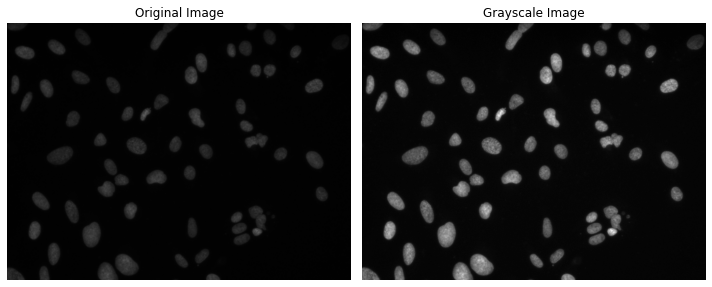

In [9]:
# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

# 배경을 제거하는 중입니다.
아마도 이 문제에 대한 가장 간단한 방법은 이미지에 관심 있는 개체와 배경이라는 두 개의 클래스가 있다고 가정하는 것입니다. 이 가정에서는 데이터가 강도의 이항 분포로 분류될 것으로 예상됩니다. 최상의 분리 값을 찾으면 배경 데이터를 "마스크"하고 남은 개체를 세어 볼 수 있습니다.

임계값을 찾을 수 있는 "가장 멍청한" 방법은 평균 또는 중위수와 같은 간단한 기술 통계량을 사용하는 것입니다. 그러나 다른 방법이 있습니다. "Otsu" 방법은 이미지를 이원 분포로 모형화하고 최적의 분리 값을 찾기 때문에 유용합니다.


In [13]:
im_gray

array([[0.01176471, 0.01176471, 0.02745098, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.01176471, 0.02352941, 0.05098039, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.01568627, 0.04313725, 0.06666667, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.16078431, 0.17254902, 0.17647059, ..., 0.00784314, 0.00784314,
        0.00784314]])

In [10]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray) # 0.0819546568627451
mask = np.where(im_gray > thresh_val, 1, 0) 

# 마스크의 큰 부분이 배경으로 간주되는지 확인합니다. -> 아니면 스위치
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

In [12]:
thresh_val

0.0819546568627451

In [14]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [15]:
np.sum(mask==0)

322049

In [16]:
np.sum(mask==1)

39871

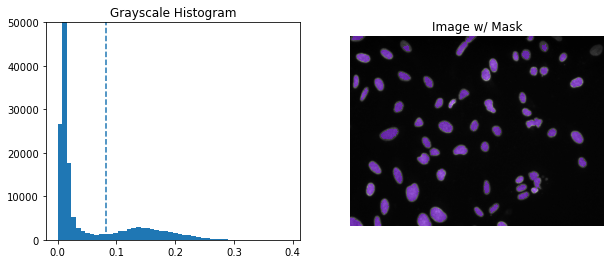

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--') # x, ymin, ymax
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

# 각 개체에 대한 개별 마스크를 도출합니다.

이번 콘테스트에서는 핵마다 마스크를 따로 받아야 합니다. 한 가지 방법은 마스크에서 연결된 모든 개체를 찾고 'ndimage.label'을 사용하여 각각에 번호를 할당하는 것입니다. 그런 다음 각 'label_id'를 루프하여 목록과 같은 반복 가능한 항목에 추가할 수 있습니다.

In [17]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)# 76

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


In [20]:
labels, nlabels = ndimage.label(mask) 
labels

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0]])

In [21]:
labels.shape

(520, 696)

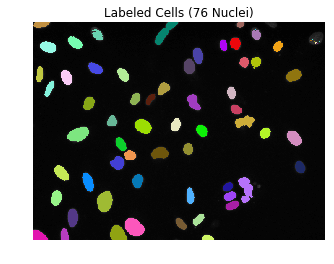

In [108]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3)) # 256행3열 0~1균일분포

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray') # 배경+흰색
plt.imshow(labels_for_display, cmap=rand_cmap) # 흰색위에 색을 덮음
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

한 눈에 보면 두 가지 문제가 있음을 알 수 있습니다(이 매우 간단한 이미지에서).

- 독립된 몇 개의 개별 픽셀이 있습니다(예: 오른쪽 상단).
- 일부 셀이 하나의 마스크로 결합됨(예: 상단-중간)
    
`ndimage find_objects`를 사용하여 마스크를 반복하면서 발견된 개별 핵을 확대하여 추가 처리 단계를 적용할 수 있습니다. `find_objects`는 이미지에서 레이블이 지정된 각 객체의 좌표 범위 목록을 반환합니다.

In [31]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    print(np.prod(cell.shape))

546
3135
252
812
572
1050
754
504
1120
550
42
936
550
675
962
972
629
896
1110
1036
936
899
640
696
567
1287
896
621
675
1410
800
1435
810
1872
676
1260
858
644
1189
644
1088
672
1295
1288
884
2135
506
760
925
1924
690
759
1125
784
2068
728
1476
560
900
377


In [32]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [22]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask) # 픽셀이 10보다 작으면 그 mask는 모두 0(검정)으로 만든다.

# Regenerate the labels
labels, nlabels = ndimage.label(mask) # 0은 검정색이라 객체검출이 안됨
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


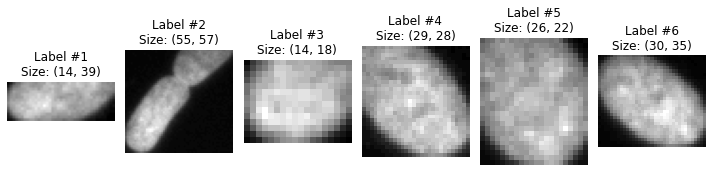

In [33]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

레이블 #2에는 "인접 셀" 문제가 있습니다. 두 셀이 동일한 개체의 일부로 간주됩니다. 여기서 할 수 있는 한 가지는 마스크를 축소하여 셀 간의 차이를 "열릴 수 있는지" 확인하는 것입니다. 이것을 마스크 침식이라고 합니다. 그런 다음 원래 비율을 복구하기 위해 다시 확장할 수 있습니다.


In [34]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

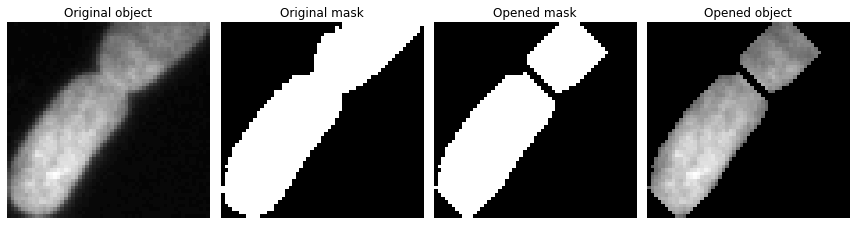

In [35]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# 레이블이 지정된 각 객체를 Run Line Encoding으로 변환
마지막으로 각 `label_mask`를 "실행 라인 인코딩" 문자열로 인코딩해야 합니다. 기본적으로 우리는 배열을 살펴보고 마스크의 일부인 픽셀을 찾으면 색인을 생성하고 얼마나 많은 후속 픽셀이 마스크의 일부인지 계산합니다. 새로운 픽셀 시작점이 보일 때마다 이것을 반복합니다.

[Kaggle user Rakhlin's kernel](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)에서 RLE를 수행하는 좋은 함수를 찾았습니다. 이 함수를 여기에 복사했습니다.


In [40]:
label_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
np.where(label_mask.T.flatten()==1)[0]

array([210074, 210075, 210076, 210077, 210078, 210079, 210592, 210593,
       210594, 210595, 210596, 210597, 210598, 210599, 211111, 211112,
       211113, 211114, 211115, 211116, 211117, 211118, 211119, 211630,
       211631, 211632, 211633, 211634, 211635, 211636, 211637, 211638,
       211639, 212149, 212150, 212151, 212152, 212153, 212154, 212155,
       212156, 212157, 212158, 212159, 212668, 212669, 212670, 212671,
       212672, 212673, 212674, 212675, 212676, 212677, 212678, 212679,
       213188, 213189, 213190, 213191, 213192, 213193, 213194, 213195,
       213196, 213197, 213198, 213199, 213708, 213709, 213710, 213711,
       213712, 213713, 213714, 213715, 213716, 213717, 213718, 213719,
       214227, 214228, 214229, 214230, 214231, 214232, 214233, 214234,
       214235, 214236, 214237, 214238, 214239, 214747, 214748, 214749,
       214750, 214751, 214752, 214753, 214754, 214755, 214756, 214757,
       214758, 214759, 215267, 215268, 215269, 215270, 215271, 215272,
      

In [53]:
def rle_encoding(x):
    '''
    x: 모양 배열(높이, 너비), 1 - 마스크, 0 - 배경입니다.
    실행 길이를 목록으로 반환합니다.
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T는 Fortran 순서를 아래로, 오른쪽으로 설정합니다.

    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0)) # [(210075, 0), ]
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [54]:
rle_encoding(label_mask)

[210075,
 6,
 210593,
 8,
 211112,
 9,
 211631,
 10,
 212150,
 11,
 212669,
 12,
 213189,
 12,
 213709,
 12,
 214228,
 13,
 214748,
 13,
 215268,
 13,
 215788,
 13,
 216308,
 13,
 216828,
 13,
 217348,
 13,
 217869,
 12,
 218389,
 12,
 218909,
 12,
 219430,
 11,
 219950,
 11,
 220471,
 10,
 220991,
 10,
 221512,
 9,
 222033,
 8,
 222554,
 7,
 223075,
 6,
 223596,
 5,
 224117,
 4,
 224639,
 2]

In [36]:
def rle_encoding(x):
    '''
    x: 모양 배열(높이, 너비), 1 - 마스크, 0 - 배경입니다.
    실행 길이를 목록으로 반환합니다.
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T는 Fortran 순서를 아래로, 오른쪽으로 설정합니다.

    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0)) # [(210075, 0), ]
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


# 하나의 함수로 결합
이제 "멍청한" 방식으로 이미지를 처리하는 기본 단계를 보았으므로 이 모든 것을 단일 기능으로 결합할 수 있습니다. 이 함수는 이미지 경로를 취하고 위에서 설명한 프로세스를 수행하고 발견된 각 마스크에 대한 RLE 문자열이 있는 데이터 프레임을 내보냅니다.

또한 데이터 세트의 모든 이미지에 대해 단일 DataFrame을 내보내는 래퍼 함수를 ​​만듭니다.

In [37]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    이미지 경로 목록(pathlib)을 가져옵니다.경로 개체), 각 개체를 분석합니다.
    제출 준비가 된 DataFrame을 반환합니다.
    '''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [39]:
testing = pathlib.Path('./input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)

C:\Users\HOME\AppData\Local\Temp/ipykernel_5592/1218554941.py:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray = rgb2gray(im)
